## Import Libraries Packages, Downloads

In [2]:
#manipulation and plotting libraries
import numpy as np
import pandas as pd
import warnings
import random
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import math as mt

warnings.filterwarnings('ignore')

In [2]:
#ML libraries
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

## Loading and Processing Data
`Note: (Because none of the processing we are doing involves imputation or such, we are doing the processing before the split)`

In [4]:
warnings.filterwarnings('ignore')


Data = pd.read_csv("formatted_data.csv")

## Plotting

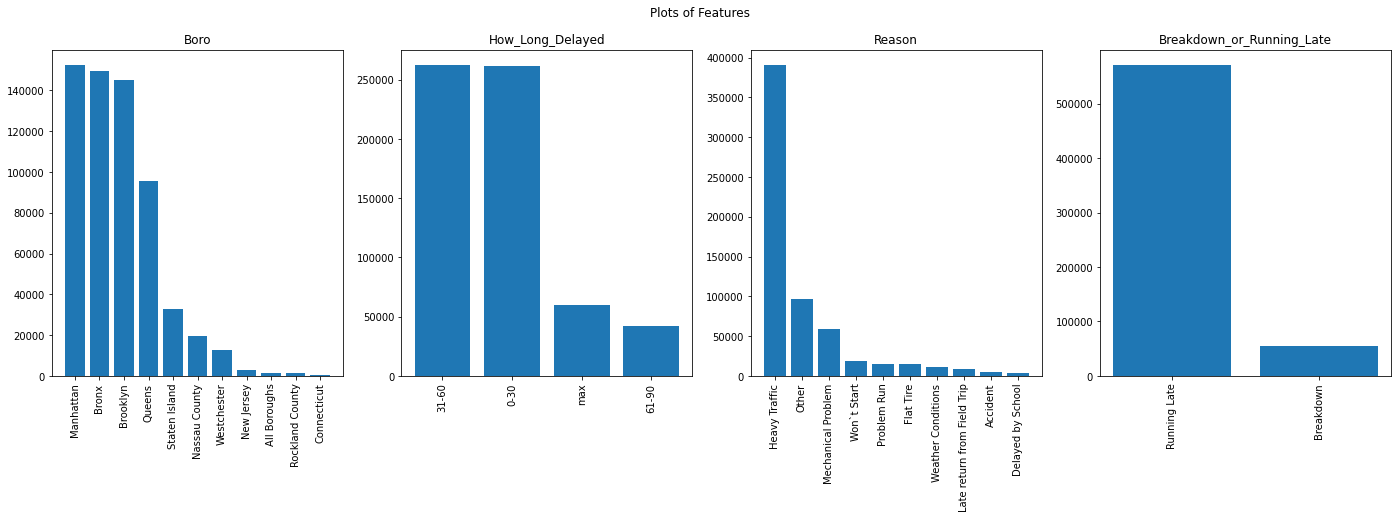

In [5]:
warnings.filterwarnings('ignore')

columns_to_plot_Data = ['Boro','How_Long_Delayed' ,'Reason', 'Breakdown_or_Running_Late']

fig, axs = plt.subplots(1,4, figsize=(24, 6))
fig.suptitle("Plots of Features")
fig.subplots_adjust(hspace = .5, wspace=.2)
axs = axs.ravel()

i = 0
for column_name in columns_to_plot_Data:

    counts = Data[column_name].value_counts()
    
    # Rotate the tick labels in the second subplot
    axs[i].bar(counts.index, counts.values)
    axs[i].set_title(f"{column_name}")
    axs[i].set_xticklabels(counts.index, rotation=90)
    i += 1



In [6]:
def process(df): 

    #copy dataframe
    data = df.copy()
    #data.columns = data.columns.astype(str)

    #making a dictionary since we need to do a lot of conversion
    to_binary = {'Yes':1, 'No':0}

    #dropping columns we won't be able to use
    data = data.drop(['Busbreakdown_ID', 'Created_On', 
            'Informed_On','Incident_Number', 
            'Last_Updated_On', 'School_Age_or_PreK', 
            'School_Year', 'Route_Number', 'Schools_Serviced',
            'Run_Type', 'Bus_No', 'Bus_Company_Name'], axis = 1)
    
    data = data.dropna()

    #mapping literals to binary values
    data['Breakdown_or_Running_Late'] = data['Breakdown_or_Running_Late'].map({'Breakdown':1, 'Running Late':0})
    data['Has_Contractor_Notified_Parents'] = data['Has_Contractor_Notified_Parents'].map(to_binary)
    data['Has_Contractor_Notified_Schools'] = data['Has_Contractor_Notified_Schools'].map(to_binary)
    data['Have_You_Alerted_OPT'] = data['Have_You_Alerted_OPT'].map(to_binary)

    #getting month/date values
    data['Occurred_On'] = pd.to_datetime(data['Occurred_On'])
    data['Year'] = data['Occurred_On'].dt.year
    data['Month'] = data['Occurred_On'].dt.month
    data['Day'] = data['Occurred_On'].dt.day
    data['Hour'] = data['Occurred_On'].dt.hour
    data['Mins'] = data['Occurred_On'].dt.minute
    data['Weekday'] = data['Occurred_On'].dt.weekday


    data["sin_month"] = np.sin(2*np.pi*data["Month"]/max(data["Month"]))
    data["cos_month"] = np.cos(2*np.pi*data["Month"]/max(data["Month"]))
    data["sin_hour"] = np.sin(2*np.pi*data["Hour"]/max(data["Hour"]))
    data["cos_hour"] = np.cos(2*np.pi*data["Hour"]/max(data["Hour"]))
    data["sin_mins"] = np.sin(2*np.pi*data["Mins"]/max(data["Mins"]))
    data["cos_mins"] = np.cos(2*np.pi*data["Mins"]/max(data["Mins"]))

    #one hot encode boro
    #data['Boro'] = data['Boro'].fillna('None')
    for boro in data['Boro'].unique():
        data[boro] = (data['Boro'] == boro).astype(int)

    # one hot encode breakdown reason
    for reason in data['Reason'].unique():
        data[reason] = (data['Reason'] == reason).astype(int)

    data = data.drop(['Boro'], axis = 1)
    data = data.drop(['Reason'], axis = 1)

    #plot some features

    i = 0
    columns_to_plot_df = ['Month', 'Day', 'Hour', 'Weekday']

    fig, axs = plt.subplots(1,4, figsize=(24, 6))
    fig.suptitle("Plots of Features")
    fig.subplots_adjust(hspace = .5, wspace=.2)
    axs = axs.ravel()

    for column_name in columns_to_plot_df:
        
        counts = data[column_name].value_counts().sort_index()
        
        # Rotate the tick labels in the second subplot
        axs[i].bar(counts.index, counts.values)
        axs[i].set_title(f"{column_name}")
        i += 1

    data = data.drop(['Occurred_On', 'Month', 'Day', 'Hour', 'Mins'], axis = 1)

    return data


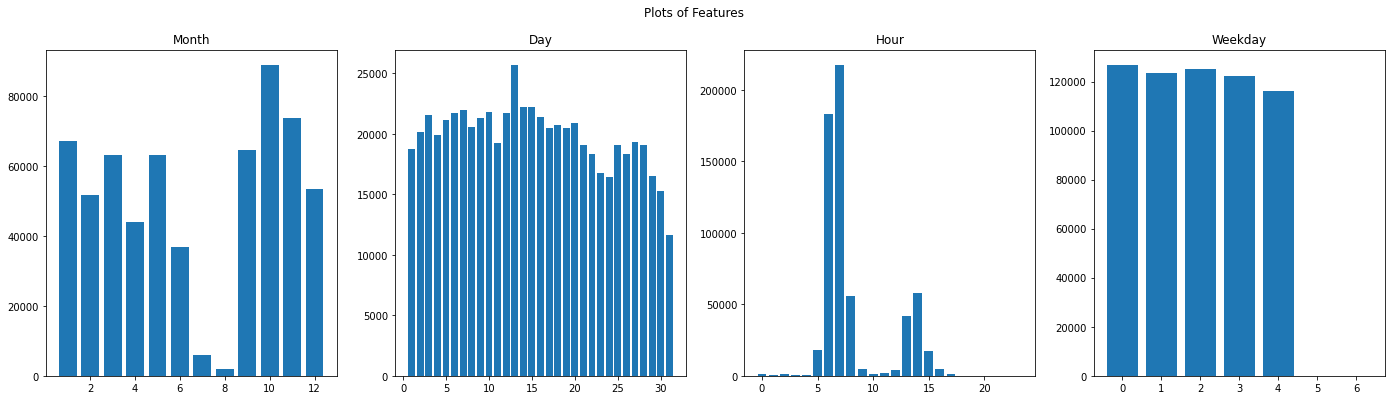

In [7]:
#Process the data
df = process(Data)


### Train Test Split

In [8]:

X = df.drop(['How_Long_Delayed'], axis = 1)
y = df['How_Long_Delayed']

X_train, X_test,y_train, y_test = train_test_split(X,y, test_size= .1)

## Building a Baseline Classifier
#### 1) (Almost) Random Guessing


In [ ]:
classes = {0:'0-30', 1: '31-60', 2:'61-90', 3:'91-120', 4:'-1'}

guess = []

for index, row in X_test.iterrows():

    int = 0

    if row.Breakdown_or_Running_Late == 1:
        int = 4
    else:
        int = 1

    guess.append(classes[int])
    
accuracy_score(y_test, guess)



#### 2) One v Rest: Logistic Regression

In [ ]:

pipe = Pipeline( steps = 
                [
                    ('scaler', StandardScaler()),
                    ('poly', PolynomialFeatures(degree = 1)),
                    ('mod', OneVsRestClassifier(estimator= LogisticRegression()))

                ])

gridcv = GridSearchCV(pipe, 
                        param_grid = {
                                        'mod': [OneVsRestClassifier(estimator= LogisticRegression())],
                                        'poly__degree':[2],
                                        'scaler': [StandardScaler()],

                                    },
                        return_train_score = True,
                        cv = 2,
                        verbose= 3
                                    )

gridcv.fit(X_train, y_train)


print(f'One vs. Rest Score: {gridcv.score(X_test, y_test)}')

In [ ]:

pipe = Pipeline( steps = 
                [
                    ('scaler', StandardScaler()),
                    ('poly', PolynomialFeatures(degree = 1)),
                    ('mod', OneVsOneClassifier(estimator= LogisticRegression()))

                ])

gridcv = GridSearchCV(pipe, 
                        param_grid = {
                                        'mod': [OneVsOneClassifier(estimator= LogisticRegression())],
                                        'poly__degree':[1],
                                        'scaler': [StandardScaler()],

                                    },
                        return_train_score = True,
                        cv = 2,
                        verbose= 3
                                    )

gridcv.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score

print(classification_report(y_test, gridcv.predict(X_test)))
balanced_accuracy_score(y_test, gridcv.predict(X_test))